In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, fbeta_score, precision_score, recall_score, average_precision_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from statsmodels.tsa.arima.model import ARIMA 
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [35]:
torch.manual_seed(42)  # Настройка воспроизводимости
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Ingestion

In [36]:
# Загрузка всех таблиц
telemetry = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_telemetry.csv")
errors = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_errors.csv")
maint = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_maint.csv")
failures = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_failures.csv")
machines = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_machines.csv")

In [37]:
# Преобразование даты
for df in [telemetry, errors, maint, failures]:
    df["datetime"] = pd.to_datetime(df["datetime"])

## Data Preprocessing

In [38]:
# Список признаков
fields = ["volt", "rotate", "pressure", "vibration"]

def create_telemetry_features(telemetry):
    telemetry = telemetry.sort_values(["machineID", "datetime"])
    telemetry["datetime_3h"] = telemetry["datetime"].dt.floor("3H")
    
    # 3h aggregates
    agg_3h = telemetry.groupby(["machineID", "datetime_3h"])[fields].agg(["mean", "std"]).reset_index()
    agg_3h.columns = ["machineID", "datetime"] + [f"{f}{s}_3h" for f in fields for s in ["mean", "sd"]]
    
    # 24h rolling (на основе часовых данных)
    telemetry_wide = telemetry.set_index("datetime")
    agg_24h_list = []
    for mid, group in telemetry_wide.groupby("machineID"):
        for f in fields:
            group[f + "mean_24h"] = group[f].rolling("24H", min_periods=1).mean()
            group[f + "sd_24h"] = group[f].rolling("24H", min_periods=1).std()
        agg_24h_list.append(group[["machineID"] + [f + "mean_24h" for f in fields] + [f + "sd_24h" for f in fields]].reset_index())
    
    agg_24h = pd.concat(agg_24h_list, ignore_index=True)
    agg_24h = agg_24h.dropna()
    
    # Объединение
    feat = agg_3h.merge(agg_24h, on=["machineID", "datetime"], how="inner")
    return feat

In [39]:
# Объединение всех признаков
telemetry_feat = create_telemetry_features(telemetry)

# Удаляем оставшиеся NaN 
telemetry_feat = telemetry_feat.dropna()

telemetry_feat.describe()

,machineID,datetime,voltmean_3h,voltsd_3h,rotatemean_3h,rotatesd_3h,pressuremean_3h,pressuresd_3h,vibrationmean_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
count,291900.000000,291900,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000
mean,50.500000,2015-07-02 18:00:00,170.776678,13.299218,446.607287,44.456528,100.857847,8.885909,40.384977,4.441110,170.776977,446.605840,100.858037,40.384634,14.916891,49.947114,10.046691,5.002247
min,1.000000,2015-01-01 09:00:00,125.532506,0.025509,211.811184,0.078991,72.118639,0.027417,26.569635,0.015278,154.022949,266.010419,84.563174,31.883282,2.495533,12.026460,1.619279,0.896217
25%,25.750000,2015-04-02 12:00:00,164.449167,8.027362,427.563180,26.903705,96.238627,5.370368,38.147883,2.684815,168.070558,441.539601,98.667943,39.353304,13.356554,44.663514,8.923512,4.460112
50%,50.500000,2015-07-02 18:00:00,170.434378,12.495658,448.383875,41.795915,100.234191,8.345785,40.145826,4.173898,170.211969,449.210851,100.098210,40.072717,14.852678,49.612699,9.921354,4.958619
75%,75.250000,2015-10-02 00:00:00,176.610611,17.688527,468.447680,59.104130,104.406034,11.790303,42.227517,5.899848,172.462699,456.369633,101.613240,40.833986,16.394477,54.825097,10.981117,5.485186
max,100.000000,2016-01-01 03:00:00,241.420717,58.444332,586.682904,179.903039,162.309656,35.659369,69.311324,18.305595,220.782618,513.761534,152.310351,61.932124,32.696413,121.544102,28.654103,13.203534
std,28.866119,NaN,9.500328,6.966039,33.129628,23.215960,7.412819,4.656252,3.478683,2.320309,4.728555,18.095457,4.744648,2.062891,2.265301,7.699836,1.716655,0.801680


In [40]:
# Уже есть: telemetry_mean_3h, telemetry_mean_24h
# Создадим признаки тренда: разница между 24h и 3h средними

for col in fields:
    short_mean = f"{col}mean_3h"
    long_mean = f"{col}mean_24h"
    trend_col = f"{col}_trend"
    telemetry_feat[trend_col] = telemetry_feat[long_mean] - telemetry_feat[short_mean]

    # Аналогично для стандартного отклонения
    short_std = f"{col}sd_3h"
    long_std = f"{col}sd_24h"
    trend_std_col = f"{col}_trend_sd"
    telemetry_feat[trend_std_col] = telemetry_feat[long_std] - telemetry_feat[short_std]

In [41]:
from scipy.fft import rfft, rfftfreq

def compute_fft_features(signal, n_peaks=2):
    N = len(signal)
    if N < 2:
        return np.zeros(2 * n_peaks)
    
    # Убираем DC-компонент (среднее)
    signal = signal - np.mean(signal)
    yf = np.abs(rfft(signal))
    xf = rfftfreq(N, d=1.0)  # Шаг = 1 (условные единицы)
    
    # Находим индексы топ-n пиков
    peak_indices = np.argsort(yf)[-n_peaks:][::-1]
    top_freqs = xf[peak_indices]
    top_amps = yf[peak_indices]
    
    # Конкатенируем и обрезаем/дополняем до 2 * n_peaks
    result = np.concatenate([top_freqs, top_amps])
    if len(result) < 2 * n_peaks:
        result = np.pad(result, (0, 2 * n_peaks - len(result)), constant_values=0)
    elif len(result) > 2 * n_peaks:
        result = result[:2 * n_peaks]

    return result

# Добавляем FFT-признаки
fft_features_list = []
window_size = 24  # Последние 24 записи (~24 ч)

for mid in telemetry["machineID"].unique():
    sub = telemetry[telemetry["machineID"] == mid].copy()
    sub = sub.sort_values("datetime")
    
    for i in range(window_size, len(sub) + 1):
        window = sub.iloc[i - window_size:i]
        row = {"machineID": mid, "datetime": window["datetime"].iloc[-1]}
        
        for col in fields:
            signal = window[col].values
            fft_vals = compute_fft_features(signal, n_peaks=2)
            for j in range(len(fft_vals)):
                row[f"{col}_fft{j}"] = fft_vals[j]
        
        fft_features_list.append(row)

# Создаём датафрейм и объединяем
fft_df = pd.DataFrame(fft_features_list)
telemetry_feat = telemetry_feat.merge(fft_df, on=["machineID", "datetime"], how="left")
telemetry_feat = telemetry_feat.fillna(0)  

In [42]:
# Найдём все FFT-колонки
fft_cols = [col for col in telemetry_feat.columns if 'fft' in col]

# Нормализация FFT-признаков
scaler_fft = StandardScaler()
telemetry_feat[fft_cols] = scaler_fft.fit_transform(telemetry_feat[fft_cols])

In [43]:
# Убедимся, что у нас есть machineID и datetime
errors["datetime"] = pd.to_datetime(errors["datetime"])
errors["datetime_3h"] = errors["datetime"].dt.floor("3H")

# Преобразуем errorID в числовые метки
errors["errorID"] = errors["errorID"].str.replace("error", "").astype(int)

# Создаём one-hot кодирование
error_dummies = pd.get_dummies(errors, columns=["errorID"], prefix="error")

# Группируем по machineID и 3-часовому времени, суммируя только числовые колонки (ошибки)
# Исключаем исходные нечисловые колонки (datetime, errorID)
id_cols = ["machineID", "datetime_3h"]
error_cols = [col for col in error_dummies.columns if col.startswith("error_")]

# Агрегируем по machineID и усреднённому времени
error_grouped = error_dummies.groupby(id_cols)[error_cols].sum().reset_index()

# Создаём 24H скользящее окно (8 окон по 3 ч)
# Для этого сначала сделаем pivot, чтобы применить rolling
temp = []
for col in error_cols:
    # Поворачиваем таблицу: строки = datetime_3h, колонки = machineID
    pt = pd.pivot_table(
        error_grouped,
        index="datetime_3h",
        columns="machineID",
        values=col,
        fill_value=0
    )
    # Скользящая сумма за 24 часа 
    rolling_sum = pt.rolling(window=8, min_periods=1).sum()
    # Ресемплируем каждые 3 часа 
    # Берём первое значение (оно же единственное) в каждом 3H интервале
    resampled = rolling_sum.resample("3H", closed="left", label="right").first()
    # Возвращаем в длинный формат
    temp.append(resampled.unstack())

# Объединяем все типы ошибок
error_count = pd.concat(temp, axis=1)
error_count.columns = [f"error{i}count" for i in range(1, 6)]

# Сбрасываем индекс, чтобы machineID и datetime стали колонками
error_count = error_count.reset_index()
error_count.rename(columns={"datetime_3h": "datetime"}, inplace=True)

# Удаляем строки, где нет данных 
error_count = error_count.dropna()

error_count.describe()

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
count,195400.000000,195400,195400.000000,195400.000000,195400.000000,195400.000000,195400.000000
mean,50.500000,2015-07-02 11:45:32.241555712,0.041351,0.040409,0.034186,0.029724,0.014575
min,1.000000,2015-01-01 09:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,2015-03-31 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.500000,2015-07-02 19:30:00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.250000,2015-10-01 21:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,2016-01-01 06:00:00,2.000000,3.000000,2.000000,2.000000,2.000000
std,28.866144,NaN,0.202971,0.200702,0.184835,0.171951,0.120823


In [44]:
# Подготовка maint
comp_rep = pd.get_dummies(maint.set_index("datetime")).reset_index()
comp_rep.columns = ["datetime", "machineID", "comp1", "comp2", "comp3", "comp4"]

# Агрегируем по machineID и datetime
comp_rep  = comp_rep.groupby(["machineID", "datetime"]).sum().reset_index()

# Добавляем временные точки, где не было замен
comp_rep = telemetry[["datetime", "machineID"]].merge(comp_rep,
                                                      on=["datetime", "machineID"],
                                                      how="outer").fillna(0).sort_values(by=["machineID", "datetime"])  # Сортируем по машине и времени 

comp_cols = ["comp1", "comp2", "comp3", "comp4"]
for comp in comp_cols:
    # Создаём бинарный флаг: была ли замена?
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), "datetime"]
    
    # Заполняем с датой последней замены компонента (по машинам)
    comp_rep[comp] = comp_rep[comp].fillna(method="ffill")

# Удаляем данные до 2015 года
comp_rep = comp_rep[comp_rep["datetime"] >= pd.to_datetime("2015-01-01")].reset_index(drop=True)
for comp in comp_cols:
    comp_rep[comp] = (comp_rep["datetime"] - comp_rep[comp]) / np.timedelta64(1, "D")

comp_rep.describe()

,datetime,machineID,comp1,comp2,comp3,comp4
count,876100,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,2015-07-02 18:00:00,50.500000,53.525185,51.540806,52.725962,53.834191
min,2015-01-01 06:00:00,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-04-02 12:00:00,25.750000,13.291667,12.125000,13.125000,13.000000
50%,2015-07-02 18:00:00,50.500000,32.791667,29.666667,32.291667,32.500000
75%,2015-10-02 00:00:00,75.250000,68.708333,66.541667,67.333333,70.458333
max,2016-01-01 06:00:00,100.000000,491.958333,348.958333,370.958333,394.958333
std,NaN,28.866087,62.491679,59.269254,58.873114,59.707978


In [45]:
# Слияние
final_feat = telemetry_feat.merge(error_count, on=["machineID", "datetime"], how="left")
final_feat = final_feat.merge(comp_rep, on=["machineID", "datetime"], how="left")
final_feat = final_feat.merge(machines, on="machineID", how="left")
final_feat = final_feat.fillna(0)

# One-hot кодирование 
final_feat = pd.get_dummies(final_feat, columns=["model"], prefix="model")
final_feat.describe()

,machineID,datetime,voltmean_3h,voltsd_3h,rotatemean_3h,rotatesd_3h,pressuremean_3h,pressuresd_3h,vibrationmean_3h,vibrationsd_3h,...,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,age
count,291900.000000,291900,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,...,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000,291900.000000
mean,50.500000,2015-07-02 18:00:00,170.776678,13.299218,446.607287,44.456528,100.857847,8.885909,40.384977,4.441110,...,0.027670,0.027044,0.022867,0.019887,0.009753,53.469000,51.477503,52.664745,53.772467,11.330000
min,1.000000,2015-01-01 09:00:00,125.532506,0.025509,211.811184,0.078991,72.118639,0.027417,26.569635,0.015278,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,2015-04-02 12:00:00,164.449167,8.027362,427.563180,26.903705,96.238627,5.370368,38.147883,2.684815,...,0.000000,0.000000,0.000000,0.000000,0.000000,13.250000,12.125000,13.125000,13.000000,6.750000
50%,50.500000,2015-07-02 18:00:00,170.434378,12.495658,448.383875,41.795915,100.234191,8.345785,40.145826,4.173898,...,0.000000,0.000000,0.000000,0.000000,0.000000,32.750000,29.625000,32.250000,32.500000,12.000000
75%,75.250000,2015-10-02 00:00:00,176.610611,17.688527,468.447680,59.104130,104.406034,11.790303,42.227517,5.899848,...,0.000000,0.000000,0.000000,0.000000,0.000000,68.625000,66.500000,67.250000,70.375000,16.000000
max,100.000000,2016-01-01 03:00:00,241.420717,58.444332,586.682904,179.903039,162.309656,35.659369,69.311324,18.305595,...,2.000000,3.000000,2.000000,2.000000,2.000000,491.875000,348.875000,370.875000,394.875000,20.000000
std,28.866119,NaN,9.500328,6.966039,33.129628,23.215960,7.412819,4.656252,3.478683,2.320309,...,0.167172,0.165286,0.152026,0.141344,0.099075,62.484891,59.255134,58.862269,59.697678,5.827625


In [46]:
# Сортировка и объединение отказов с признаками по времени
failures["datetime"] = pd.to_datetime(failures["datetime"])
failures = failures.sort_values(["machineID", "datetime"])

# Бинарные метки для прогнозирования отказа в ближайшие H часов
def create_binary_failure_labels(features_df, failures_df, horizons_hours=[24, 48, 168]):
    """
    Создаёт бинарные метки: будет ли отказ (comp1-comp4) в ближайшие H часов.
    """
    features_df = features_df.copy()
    features_df["datetime"] = pd.to_datetime(features_df["datetime"])
    failures_df = failures_df.copy()
    failures_df["datetime"] = pd.to_datetime(failures_df["datetime"])
    
    # Все времена отказов по машинам
    all_failure_times = failures_df.groupby("machineID")["datetime"].apply(list).to_dict()
    
    # Инициализация
    for h in horizons_hours:
        features_df[f"failure_in_{h}h"] = 0
    
    # Помечаем отказы
    for idx, row in tqdm(features_df.iterrows(), total=len(features_df), desc="Binary labeling"):
        mid = row["machineID"]
        t_now = row["datetime"]
        
        if mid not in all_failure_times:
            continue
            
        future_fails = [ft for ft in all_failure_times[mid] if ft > t_now]
        if not future_fails:
            continue
            
        next_fail = min(future_fails)
        
        for h in horizons_hours:
            if (next_fail - t_now).total_seconds() <= h * 3600:
                features_df.at[idx, f"failure_in_{h}h"] = 1
                break  # Попал в ближайший горизонт
    
    return features_df

# Применяем 
labeled_features = create_binary_failure_labels(final_feat, failures, horizons_hours=[24, 48, 168])

labeled_features.head()

Binary labeling: 100%|██████████| 291900/291900 [00:04<00:00, 64550.54it/s]


,machineID,datetime,voltmean_3h,voltsd_3h,rotatemean_3h,rotatesd_3h,pressuremean_3h,pressuresd_3h,vibrationmean_3h,vibrationsd_3h,...,comp3,comp4,age,model_model1,model_model2,model_model3,model_model4,failure_in_24h,failure_in_48h,failure_in_168h
0,1,2015-01-01 09:00:00,164.192565,7.596570,403.949857,50.120452,105.687417,8.555032,34.255891,7.662229,...,154.125,169.125,18,False,False,True,False,0,0,1
1,1,2015-01-01 12:00:00,168.134445,10.124584,435.781707,55.084734,107.793709,5.909721,41.239405,5.169304,...,154.250,169.250,18,False,False,True,False,0,0,1
2,1,2015-01-01 15:00:00,165.514453,4.673269,430.472823,42.047278,101.703289,4.554047,40.373739,2.106108,...,154.375,169.375,18,False,False,True,False,0,0,1
3,1,2015-01-01 18:00:00,168.809347,14.752132,437.111120,47.048609,90.911060,4.244158,41.738542,2.207884,...,154.500,169.500,18,False,False,True,False,0,0,1
4,1,2015-01-01 21:00:00,168.779396,15.901952,486.242664,36.129552,90.446472,4.310741,41.796657,9.390494,...,154.625,169.625,18,False,False,True,False,0,0,1


In [47]:
# Глобальный временной сплит
split_time_bin = labeled_features["datetime"].quantile(0.8)
train_mask_bin = labeled_features["datetime"] < split_time_bin
val_mask_bin = labeled_features["datetime"] >= split_time_bin

# Признаки 
feature_cols = [col for col in labeled_features.columns if not col.startswith("failure_in_") 
                and col not in ["datetime", "machineID"]]

## Construction of a binary label (24h before failure)

In [48]:
horizon = 24  # Задаем горизонт отказа

# Признаки и метки
X_bin = labeled_features[feature_cols].copy()
X_bin = pd.get_dummies(X_bin, drop_first=False)
X_bin = X_bin.fillna(0)

# Целевая переменная
y_bin = labeled_features[f"failure_in_{horizon}h"].values

# Train/val
X_train_bin = X_bin.loc[train_mask_bin].values.astype(np.float32)
y_train_bin = y_bin[train_mask_bin].astype(np.int64)

X_val_bin = X_bin.loc[val_mask_bin].values.astype(np.float32)
y_val_bin = y_bin[val_mask_bin].astype(np.int64)

In [49]:
# Балансировка: undersample превалирующего класса ("no failure")
from collections import Counter
print("Distribution before:", Counter(y_train_bin))

from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy=0.3, random_state=42) 
X_train_bal, y_train_bal = undersampler.fit_resample(X_train_bin, y_train_bin)

print("Distribution after:", Counter(y_train_bal))

Distribution before: Counter({np.int64(0): 228839, np.int64(1): 4661})
Distribution after: Counter({np.int64(0): 15536, np.int64(1): 4661})


## Normalization and tensors

In [50]:
# Масштабирование
scaler_bin = StandardScaler()
X_train_scaled_bin = scaler_bin.fit_transform(X_train_bin)
X_val_scaled_bin = scaler_bin.transform(X_val_bin)

# Тензоры 
X_train_t = torch.tensor(X_train_scaled_bin, dtype=torch.float32).to(device)
X_val_t = torch.tensor(X_val_scaled_bin, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train_bin, dtype=torch.long).to(device)
y_val_t = torch.tensor(y_val_bin, dtype=torch.long).to(device)

# Создание DataLoader
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=256, shuffle=False)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=256, shuffle=False)

input_size_bin = X_train_scaled_bin.shape[1]
n_classes_bin = 2

## Modelling

In [51]:
class DLinear(nn.Module):
    def __init__(self, input_size, n_classes=5, dropout=0.5):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        # Веса для seasonal и trend компонент
        output_dim = n_classes
        self.linear_seasonal = nn.Linear(input_size, output_dim)
        self.linear_trend = nn.Linear(input_size, output_dim)

    def forward(self, x):
        x = self.dropout(x)
        out = self.linear_seasonal(x) + self.linear_trend(x)
        return out  # (B, n_classes)

In [52]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, n_classes=5, nhead=4, num_layers=1, dropout=0.5):
        super().__init__()
        self.proj = nn.Linear(input_size, hidden_size)
        
        # TransformerEncoderLayer включает dropout 
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=nhead,
            dim_feedforward=128,
            dropout=dropout,      # Регуляризация внимания и FFN
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)  # Дополнительный dropout перед классификатором
        self.fc = nn.Linear(hidden_size, n_classes)

    def forward(self, x):
        x = self.proj(x)               # (B, hidden_size)
        x = x.unsqueeze(1)             # (B, 1, hidden_size)
        x = self.transformer(x)        # (B, 1, hidden_size)
        x = x[:, 0, :]                 # (B, hidden_size)
        x = self.dropout(x)            # Регуляризация выхода
        return self.fc(x)

In [53]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=16, n_classes=5, dropout=0.6):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, n_classes)
        
    def forward(self, x):
        x = x.unsqueeze(1)  # (B, 1, input_size)
        _, (h, _) = self.lstm(x)  # h: (1, B, hidden_size)
        h_last = self.dropout(h[-1])  # (B, hidden_size)
        out = self.fc(h_last) 
        return out  # (B, n_classes)

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size=16, n_classes=5, dropout=0.6):
        super().__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, n_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        _, h = self.gru(x)
        h_last = self.dropout(h[-1])
        out = self.fc(h_last) 
        return out

Binary model training function (single cycle).

In [57]:
import copy

def Evaluate(model_class, model_params, X_train, y_train, X_val, y_val, device, horizon, epochs=100):
    # Модель
    model = model_class(input_size=input_size_bin, n_classes=2, **model_params).to(device)
    
    # Обучение
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    best_f2 = 0
    patience = 10
    counter = 0
    
    for epoch in range(epochs):
        model.train()
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
        
        # Валидация
        model.eval()
        y_true, y_proba = [], []
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                out = model(X)
                prob = torch.softmax(out, dim=1)[:, 1]
                y_true.append(y.cpu().numpy())
                y_proba.append(prob.cpu().numpy())
        y_true = np.concatenate(y_true)
        y_proba = np.concatenate(y_proba)
        f2 = fbeta_score(y_true, y_proba > 0.5, beta=2, zero_division=0)
        
        if f2 > best_f2:
            best_f2 = f2
            counter = 0
            best_state = copy.deepcopy(model.state_dict())
        else:
            counter += 1
            if counter >= patience:
                break
    
    model.load_state_dict(best_state)
    
    # Подбор порога
    thresholds = np.linspace(0.1, 0.9, 50)
    f2_scores = [fbeta_score(y_true, y_proba > t, beta=2, zero_division=0) for t in thresholds]
    best_t = thresholds[np.argmax(f2_scores)]
    y_pred = (y_proba > best_t).astype(int)
    
    return {
        "model": model_class.__name__,
        "horizon": horizon,
        "F2": fbeta_score(y_true, y_pred, beta=2),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "AUC-PR": average_precision_score(y_true, y_proba)
    }

## Training   

In [58]:
# Определяем модели и их параметры
models_config = [
    (DLinear, {"dropout": 0.5}),
    (LSTMModel, {"hidden_size": 64, "dropout": 0.6}),
    (GRUModel, {"hidden_size": 64, "dropout": 0.6}),
    (TransformerModel, {"hidden_size": 32, "nhead": 4, "num_layers": 1, "dropout": 0.5})
]

# Подготовка данных для каждого горизонта
horizons = [24, 48, 168]
binary_results = []

for horizon in horizons:
    # Обучение всех моделей
    for model_class, params in models_config:
        try:
            result = Evaluate(
                model_class, params, X_train_bin, y_train_bin, X_val_bin, y_val_bin, device, horizon
            )
            binary_results.append(result)
        except Exception as e:
            print(f"Error training {model_class.__name__} for {horizon}h: {e}")
            binary_results.append({
                "model": model_class.__name__,
                "horizon": horizon,
                "F2": 0,
                "Precision": 0,
                "Recall": 0,
                "AUC-PR": 0
            })

In [69]:
# Бинарная классификация
binary_df = pd.DataFrame(binary_results)

print("Binary Classification:")
print(binary_df)

Binary Classification:
               model  horizon        F2  Precision    Recall    AUC-PR
0            DLinear       24  0.513493   0.479021  0.522901  0.447029
1          LSTMModel       24  0.741215   0.520359  0.829198  0.805082
2           GRUModel       24  0.715476   0.474324  0.819656  0.780341
3   TransformerModel       24  0.718965   0.435414  0.858779  0.779872
4            DLinear       48  0.490534   0.494696  0.489504  0.451608
5          LSTMModel       48  0.726357   0.455657  0.853053  0.793500
6           GRUModel       48  0.723917   0.493395  0.819656  0.790804
7   TransformerModel       48  0.728712   0.451678  0.860687  0.807292
8            DLinear      168  0.487712   0.484390  0.488550  0.443605
9          LSTMModel      168  0.728779   0.500581  0.822519  0.798285
10          GRUModel      168  0.714751   0.450256  0.837786  0.780009
11  TransformerModel      168  0.728164   0.521552  0.808206  0.799104


F2-score по моделям и горизонтам.

In [67]:
f2_pivot = binary_df.pivot_table(
    index="model", 
    columns="horizon", 
    values="F2",
    aggfunc="mean"
).round(3)

print("F2-score:")
print(f2_pivot)

F2-score:
horizon             24     48     168
model                                
DLinear           0.513  0.491  0.488
GRUModel          0.715  0.724  0.715
LSTMModel         0.741  0.726  0.729
TransformerModel  0.719  0.729  0.728


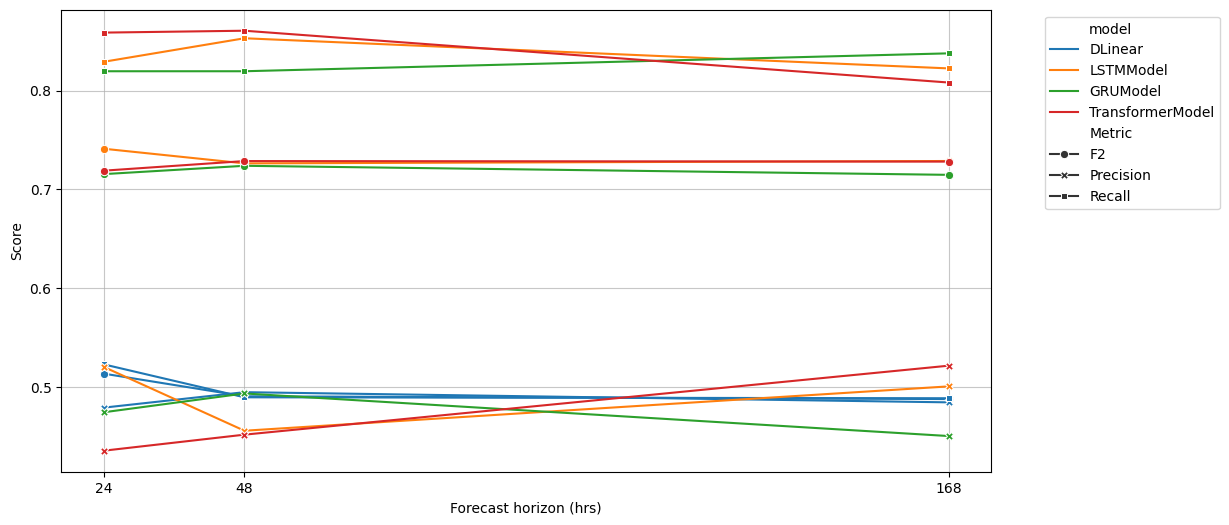

In [64]:
# Метрики для графика
plot_data = binary_df.melt(
    id_vars=["model", "horizon"],
    value_vars=["F2", "Precision", "Recall"],
    var_name="Metric",
    value_name="Score"
)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=plot_data,
    x="horizon",
    y="Score",
    hue="model",
    style="Metric",
    markers=True,
    dashes=False
)
plt.xlabel("Forecast horizon (hrs)")
plt.ylabel("Score")
plt.xticks([24, 48, 168])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.7)
plt.show()